# Woodswallow analysis
This file shows the analytical steps from the fasta files to the figures for the woodswallow manuscript: Sustained plumage divergence despite weak genomic differentiation and broad sympatry in sister species of Australian woodswallows (Artamus spp.) 

### Set up
Loading the relevant libraries, defining functions, and other relevant dictionaries

In [1]:
## Load libraries
import sys, os
import numpy
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import math
import scipy.stats
import pandas as pd
import seaborn as sns
import statistics
from matplotlib.colors import LinearSegmentedColormap
import random

In [2]:
## Define functions
def import_fasta(fa_file):
    seqs = {}
    for l in open(fa_file,'r'):
        i = l.strip()
        if i.startswith('>'):
            fasta_header = i[1:]
        else:
            seqs[fasta_header] = i
    return seqs


def extract_alleles_all(seqs):
	allele_dict = {}
	seqlen = len(seqs[list(seqs.keys())[0]])
	for bp in range(seqlen):
		alleles = {}
		for seq in seqs:
			species = seq.split('_')[1]
			base = seqs[seq][bp]
			if base == '-':
				pass
			else:
				if base not in alleles:
					alleles[base] = {species:1}
				elif base in alleles:
					if species not in alleles[base]:
						alleles[base][species] = 1
					elif species in alleles[base]:
						alleles[base][species] += 1
		if len(alleles.keys()) == 2:
			allele_dict[bp] = alleles
	for var in allele_dict:
		alleles = list(allele_dict[var].keys())
		for sp in allele_dict[var][alleles[0]]:
			if sp not in allele_dict[var][alleles[1]]:
				allele_dict[var][alleles[1]][sp] = 0
		for sp in allele_dict[var][alleles[1]]:
			if sp not in allele_dict[var][alleles[0]]:
				allele_dict[var][alleles[0]][sp] = 0
	return(allele_dict)


def extract_alleles_ingroup(seqs, ingroup):
	allele_dict = {}
	seqlen = len(seqs[list(seqs.keys())[0]])
	for bp in range(seqlen):
		alleles = {}
		for seq in seqs:
			species = seq.split('_')[1]
			if species in ingroup:
				base = seqs[seq][bp]
				if base == '-':
					pass
				else:
					if base not in alleles:
						alleles[base] = {species:1}
					elif base in alleles:
						if species not in alleles[base]:
							alleles[base][species] = 1
						elif species in alleles[base]:
							alleles[base][species] += 1
		if len(alleles.keys()) == 2:
			allele_dict[bp] = alleles
	return(allele_dict)

def compare_variants(allvars,ingroupvars):
	allvarpos = list(allvars.keys())
	ingroupvarspos = list(ingroupvars.keys())
	biallelic_in_ingroup = {}
	for var in allvarpos:
		if var in ingroupvarspos:
			biallelic_in_ingroup[var] = allvars[var]
	return biallelic_in_ingroup

def write_out(variants,locus):
	for var in variants:
		alleles = []
		for allele in variants[var]:
			alleles.append(allele)
		alleleA_spp = len(variants[var][alleles[0]].keys())
		alleleB_spp = len(variants[var][alleles[1]].keys())
		if alleleA_spp > 2 and alleleB_spp > 2: 
			continue
		elif alleleA_spp <= 2 and alleleB_spp <= 2:
			print(variants[var])
		elif alleleA_spp > 2 and alleleB_spp <= 2:
			anc_allele, der_allele = alleles[0], alleles[1]
		elif alleleA_spp <= 2 and alleleB_spp > 2:
			anc_allele, der_allele = alleles[1], alleles[0]
		wbws_anc, wbws_der, maws_anc, maws_der = 0,0,0,0
		try: wbws_anc += variants[var][anc_allele]['WBWS']
		except KeyError: pass
		try: wbws_der += variants[var][der_allele]['WBWS']
		except KeyError: pass
		try: maws_anc += variants[var][anc_allele]['MAWS']
		except KeyError: pass
		try: maws_der += variants[var][der_allele]['MAWS']
		except KeyError: pass
		outfile.write('{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\t{7}\n'.format(locus,var,anc_allele,der_allele,wbws_anc, wbws_der, maws_anc, maws_der))



In [62]:
## Define popgen functions
def FstHudson_n(w,x,y,z):
    nA, nB, pA, pB = int(y), int(z), float(w), float(x)
    qA = 1-pA
    qB = 1-pB
    num = (pA-pB)**2 - ((pA*qA)/(nA-1)) - ((pB*qB)/(nB-1))
    return(num)

def FstHudson_d(w,x,y,z):
  nA, nB, pA, pB = int(y), int(z), float(w), float(x)
  qA = 1-pA
  qB = 1-pB
  den = pA*qB + pB*qA
  return(den)

def calcDxy(x,y):
  dxy = x*(1-y) + y*(1-x)
  return dxy

def calcPi(p,k):
    try: pi = (k/(k-1))*2*p*(1-p)
    except ZeroDivisionError:
        pi = 0
    return pi
    

def calcTheta(S,n):
    denom = 0
    for k in range(1,n):
        denom += 1/k
    if S == 0:
        theta = 0
    else:
        theta = S/denom
    return theta

def TajimasD(pi, S, n):
    a1 = 0
    a2 = 0
    for k in range(1,n):
        a1 += (1/k)
        a2 += 1/(k**2)
    
    try:b1 = (n+1)/(3*(n-1))
    except ZeroDivisionError:
        b1 = 0
    try: b2 = (2*(n**2 + n + 3))/(9*n*(n-1))
    except ZeroDivisionError:
        b2 = 0    
    try: c1 = b1 - 1/a1
    except ZeroDivisionError:
        c1 = b1
    try: c2 = b2 - (n+2)/(a1*n) + a2/(a1**2)
    except ZeroDivisionError:
        c2 = b2
        
    try: e1 = c1/a1
    except ZeroDivisionError:
        e1 = 0
    try: e2 = c2/(a1**2 + a2)
    except ZeroDivisionError:
        e2 = 0
    
    try:
        D = (pi - (S/a1))/math.sqrt(e1*S + e2*S*(S-1))
    except ZeroDivisionError:
        try: D = pi - (S/a1)
        except ZeroDivisionError:
                D = pi
    return D

def calcAIC(llhood,params):
    aic = 2 * params - 2 * llhood/0.4342945
    return aic

In [31]:
## Load relevant dictionaries
## Calculate locus lengths
## Fasta file has one randomly chosen individual per locus simply to record locus lengths

working_directory = '/home/jpenalba/Dropbox/Research/Woodswallows/WOSW.fasta_files/1-add_species/00-final_analyses'
fasta_directory = '/home/jpenalba/Dropbox/Research/Woodswallows/WOSW.fasta_files/1-add_species/autosomal/fasta_files'

locus_lengths = {}
for l in open('ddrad_loci.fasta'):
    i = l.strip().split()
    if i[0].startswith('>'):
        locus = i[0].split('_')[0]
        locus = locus[1:]
    else:
        locus_lengths[locus] = len(i[0])
tot = 0
for locus in locus_lengths:
    tot += locus_lengths[locus]

print('Total sequence length is {0} bp'.format(tot))

Total sequence length is 582775 bp


### Data parsing
The data was in fasta format. This parses it to genotype and allele frequency formats that are easier to handle.

In [9]:
## This produces unfiltered allele counts

species = ['WBWS','MAWS','DUWS','BFWS','LIWS','WBRE']

outfile = open('01__alleleCounts_unfiltered.txt','w')
outfile.write('locus\tbase\talleleA,alleleB\t{0}\n'.format('\t'.join(species)))


for f in os.listdir(fasta_directory):
	if f.endswith('fa'):
		locus = f.split('.')[0]
		fasta_seq = import_fasta('{0}/{1}'.format(fasta_directory,f))
		allspp_biallelic = extract_alleles_all(fasta_seq)
		for var in allspp_biallelic:
			alleles = list(allspp_biallelic[var].keys())
			alleleA, alleleB = alleles[0], alleles[1]
			outfile.write('{0}\t{1}\t{2},{3}'.format(locus, var, alleleA, alleleB))
			for sp in species:
				try: outfile.write('\t{0},{1}'.format(allspp_biallelic[var][alleleA][sp],allspp_biallelic[var][alleleB][sp]))
				except KeyError: outfile.write('\t-,-')
			outfile.write('\n')

outfile.close()

In [10]:
# This retains loci that are fixed across all outgroup species

infile = open('01__alleleCounts_unfiltered.txt','r')
outfile = open('02a__alleleCounts_fixedinoutgroup.txt','w')
outfile.write('locus\tbp\tanc,der\tWBWS\tMAWS\n')

infile.readline()

for l in infile:
        i = l.strip().split()
        locus, bp, alleleA, alleleB = i[0], i[1], i[2][0], i[2][2]
        wbws, maws = i[3].split(','), i[4].split(',')
        duws, bfws, liws, wbre = i[5].split(','), i[6].split(','), i[7].split(','), i[8].split(',')
        alleleA_out = set([duws[0], bfws[0],liws[0],wbre[0]])
        alleleB_out = set([duws[1], bfws[1],liws[1],wbre[1]])
        if '-' in alleleA_out: alleleA_out = alleleA_out.remove('-')
        if '-' in alleleB_out: alleleB_out = alleleB_out.remove('-')
        if alleleA_out == None or alleleB_out == None: 
                continue
        if len(alleleA_out) == 1 or len(alleleB_out) == 1 and list(alleleB_out)[0] == '0':
                if list(alleleA_out)[0] == '0': 
                        outfile.write('{0}\t{1}\t{2},{3}\t{4},{5}\t{6},{7}\n'.format(locus, bp, alleleB, alleleA, wbws[1], wbws[0], maws[1], maws[0]))
                elif list(alleleB_out)[0] == '0':
                        outfile.write('{0}\t{1}\t{2},{3}\t{4},{5}\t{6},{7}\n'.format(locus, bp, alleleA, alleleB, wbws[0], wbws[1], maws[0], maws[1]))

infile.close()
outfile.close()

In [11]:
# This script filters out singletons and invariant sites

infile = open('01__alleleCounts_unfiltered.txt','r')
outfile = open('02b__alleleCounts_noSingletons.txt','w')
outfile.write(infile.readline())

for l in infile:
    i = l.strip().split()
    wbws, maws = i[3].split(','), i[4].split(',')
    if '-' in wbws or '-' in maws:
        continue
    if int(wbws[0])+int(wbws[1]) < 10 or int(maws[0])+int(maws[1]) < 10: # filter for few genotypes
        continue
    if '0' in i[3] and '1' in i[4]: # filter for singleton in MAWS
        continue
    elif '0' in i[4] and '1' in i[3]: # filter for singeltons in WBWS
        continue
    elif '0' in i[3] and '0' in i[4]:
        wbws, maws = i[3].split(','), i[4].split(',')
        if wbws[0] == '0' and maws[0] == '0': #filter for fixed
            continue
        elif wbws[1] == '0' and maws[1] == '0':
            continue
        else:
            outfile.write(l)
    else:
        outfile.write(l)

infile.close()
outfile.close()

In [12]:
# This script filters out sites with a lot of missing data

infile = open('01__alleleCounts_unfiltered.txt','r')
outfile = open('02c__alleleCounts_noLowMissingData.txt','w')
outfile.write(infile.readline())

for l in infile:
    i = l.strip().split()
    wbws, maws, duws = i[3].split(','), i[4].split(','), i[5].split(',')
    bfws, liws, wbre = i[6].split(','), i[7].split(','), i[8].split(',')
    if '-' in wbws or '-' in maws or '-' in duws or '-' in bfws or '-' in liws or '-' in wbre:
        continue
    if int(wbws[0])+int(wbws[1]) < 10 or int(maws[0])+int(maws[1]) < 10: # filter for few genotypes
        continue
    else:
        outfile.write(l)

infile.close()
outfile.close()

In [20]:
# This script filters out singletons and invariant sites

infile = open('02a__alleleCounts_fixedinoutgroup.txt','r')
outfile = open('02d__alleleCounts_fixedinoutgroup_noSingletons.txt','w')
outfile.write(infile.readline())

for l in infile:
	i = l.strip().split()
	wbws, maws = i[3].split(','), i[4].split(',')
	if int(wbws[0])+int(wbws[1]) < 10 or int(maws[0])+int(maws[1]) < 10: # filter for few genotypes
		continue
	if '0' in i[3] and '1' in i[4]: # filter for singleton in MAWS
		continue
	elif '0' in i[4] and '1' in i[3]: # filter for singeltons in WBWS
		continue
	elif '0' in i[3] and '0' in i[4]:
		wbws, maws = i[3].split(','), i[4].split(',')
		if wbws[0] == '0' and maws[0] == '0': #filter for fixed
			continue
		elif wbws[1] == '0' and maws[1] == '0':
			continue
		else:
			outfile.write(l)
	else:
		outfile.write(l)

infile.close()
outfile.close()

In [21]:
# Creates file with SNPs fixed in outgroup, no singletons, and one per locus. 
# Usage: STRUCTURE

infile = open("02d__alleleCounts_fixedinoutgroup_noSingletons.txt",'r')
outfile = open("02e__alleleCounts_fixedinoutgroup_noSingletons_oneperlocus.txt",'w')

outfile.write(infile.readline())

loci = {}
for l in infile:
	i = l.strip().split()
	locus = i[0]
	if locus not in loci:
		loci[locus] = {i[1]:[i[2],i[3],i[4]]}
	elif locus in loci:
		loci[locus][i[1]] = [i[2],i[3],i[4]]

for locus in loci:
	snps = list(loci[locus].keys())
	nsnps = len(snps)
	pickedsnp = snps[random.randrange(nsnps)-1]
	outfile.write('{0}\t{1}\t{2}\n'.format(locus,pickedsnp,'\t'.join(loci[locus][pickedsnp])))
infile.close()
outfile.close()

In [22]:
# Creates file with SNPs fixed in outgroup and one per locus.
# Usage: jSFS

infile = open("02a__alleleCounts_fixedinoutgroup.txt",'r')
outfile = open("02f__alleleCounts_fixedinoutgroup_oneperlocus.txt",'w')

outfile.write(infile.readline())

loci = {}
for l in infile:
	i = l.strip().split()
	locus = i[0]
	if locus not in loci:
		loci[locus] = {i[1]:[i[2],i[3],i[4]]}
	elif locus in loci:
		loci[locus][i[1]] = [i[2],i[3],i[4]]

for locus in loci:
	snps = list(loci[locus].keys())
	nsnps = len(snps)
	pickedsnp = snps[random.randrange(nsnps)-1]
	outfile.write('{0}\t{1}\t{2}\n'.format(locus,pickedsnp,'\t'.join(loci[locus][pickedsnp])))
infile.close()
outfile.close()

###  Finding genome location
The loci were BLASTed against the Corvus moneduloides genome to find the likely location. The output of that BLAST was used as the input for these next scripts

In [16]:
infile = open('03a__ddrad_cormon.1e-2.blast.wordsize','r')
outfile = open('03b__blast_summary_cormon.txt','w')
omitted = set()
loci = {}

for l in infile:
    i = l.strip().split()
    loc, chrom, start, end, score = i[0], i[1], int(i[8]), int(i[9]), float(i[11])
    if loc in omitted:
        continue
    else:
        loc_mid = start + (end-start)/2
        if loc not in loci:
            loci[loc] = [chrom, loc_mid, score]
        elif loc in loci:
            score_diff = loci[loc][2] - score
            if score_diff >= 10:
                omitted.add(loc)
            elif score_diff < 10:
                omitted.add(loc)
                del loci[loc]

infile.close()
perChrom = {}
for loc in loci:
    chrom, mid = loci[loc][0], int(str(loci[loc][1])[:-2])
    if chrom not in perChrom:
        perChrom[chrom] = {mid:loc}
    elif chrom in perChrom:
        perChrom[chrom][mid] = loc

outfile.write('locus\tchrom\tbp\n')
chroms = list(perChrom.keys())
chroms.sort()

for chrom in chroms:
    locs = list(perChrom[chrom].keys())
    locs.sort()
    for loc in locs:
        outfile.write('{0}\t{1}\t{2}\n'.format(perChrom[chrom][loc],chrom,loc))
outfile.close()


In [17]:
blast_file = open('03b__blast_summary_cormon.txt','r')
infile = open('02c__alleleCounts_noLowMissingData.txt','r')
outfile = open('04a__alleleCounts_noLowMissingData_blastlocs_cormon.txt','w')

blast_file.readline()

locations = {}

for l in blast_file:
        i = l.strip().split()
        locus, chrom, loc = i[0].split('_')[0], i[1], i[2]
        locations[locus] = '{0}_{1}'.format(chrom,loc)

blast_file.close()




outfile.write(infile.readline())

for l in infile:
        i = l.strip().split()
        loc = i[0]
        if loc in locations:
                outfile.write('{0}_{1}\t{2}\t{3}\t{4}\t{5}\t{6}\t{7}\t{8}\t{9}\n'.format(loc,locations[loc],i[1],i[2],i[3],i[4],i[5],i[6],i[7],i[8]))
        elif loc not in locations:
                outfile.write('{0}_chrUnkn\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\t{7}\t{8}\n'.format(loc,i[1],i[2],i[3],i[4],i[5],i[6],i[7],i[8]))

infile.close()
outfile.close()

## Population structure

**PCA**

The PCA was generated using smartPCA. These scripts were used to prepare the input files and plot the output files.

In [14]:
## Creating a genotype file

### Filtering the allele file
allele_dict = {}
infile = open('02c__alleleCounts_noLowMissingData.txt','r')
infile.readline()
for l in infile:
    i = l.strip().split()
    loc, base, alleles = i[0], int(i[1]), i[2].split(',')
    if loc not in allele_dict:
        allele_dict[loc] = {base:alleles}
    elif loc in allele_dict:
        allele_dict[loc][base] = alleles
infile.close()

spp = ['WBWS','MAWS','DUWS','BFWS','LIWS','WBRE']
samples = ['B20997_WBWS_M', 'B20998_WBWS_M', 'B31975_WBWS_F', 'B31977_WBWS_M', 
           'B32024_WBWS_M', 'B34756_WBWS_M', 'B34806_WBWS_F', 
           'B55611_WBWS_F', 'B55612_WBWS_M', 'B55613_WBWS_M', 'B55614_WBWS_F', 
           'B57329_WBWS_F', 'B28928_MAWS_F', 'B28926_MAWS_F', 'B28927_MAWS_F', 
           'B28986_MAWS_M', 'B31976_MAWS_F', 'B34842_MAWS_F', 'B48972_MAWS_F', 
           'B49864_MAWS_M', 'B55460_MAWS_M', 'B55461_MAWS_F', 'B55462_MAWS_F', 
           'B55628_MAWS_M', 'B55629_MAWS_M', 'B55646_MAWS_M', 'B55647_MAWS_M', 
           'B55648_MAWS_M', 'B57425_MAWS_M', 'B57426_MAWS_F', 'B57427_MAWS_F', 
           'B29165_DUWS_M', 'B45384_DUWS_M', 'B52827_DUWS_M', 'B54117_BFWS_M', 
           'B56614_BFWS_M', 'B57555_BFWS_M', 'B33245_LIWS_F', 'B55145_LIWS_F', 
           'B57421_LIWS_F', 'B47887_WBRE_M', 'B50622_WBRE_F', 'B57346_WBRE_M']

outfile = open('05a__genotypes_noLowMissingData.txt','w')
outfile.write('locus\tposition\talleles\t{0}\n'.format('\t'.join(samples)))

for locus in allele_dict:
    allele_ID = {}
    fa = import_fasta('{0}/{1}.fa'.format(fasta_directory,locus))
    allele_ID[locus] = {}

    for base in allele_dict[locus]:
        allele_ID[locus][base] = {}
        for seq in fa:
            ind_info = seq.split('_')
            ind = '{0}_{1}_{2}'.format(ind_info[0][:-1], ind_info[1], ind_info[2])
            allele = fa[seq][base]
            if ind not in allele_ID[locus][base]:
                allele_ID[locus][base][ind] = [allele]
            elif ind in allele_ID[locus][base]:
                allele_ID[locus][base][ind].append(allele)

    positions = list(allele_ID[locus].keys())
    positions.sort()
    for pos in positions:
        genos = []
        for sample in samples:
            if sample not in allele_ID[locus][pos]:
                genos.append('-')
            else:
                alleles = allele_ID[locus][pos][sample]
                ref_allele = allele_dict[locus][pos][1]
                if len(alleles) == 1:
                    if alleles[0] == ref_allele:
                        genos.append('2')
                    elif alleles[0] != ref_allele:
                        genos.append('0')
                elif len(alleles) == 2:
                        genos.append(str(alleles.count(ref_allele)))   
        outfile.write('{0}\t{1}\t{2}\t{3}\n'.format(locus,pos,','.join(allele_dict[locus][pos]),'\t'.join(genos)))

outfile.close()

In [23]:
#Create dictionary of of unique SNPs
infile = open('02d__alleleCounts_fixedinoutgroup_noSingletons.txt','r')
infile.readline()
uniqSNPs = {}
for l in infile:
    i = l.strip().split()
    uniqSNPs[i[0]] = int(i[1])
infile.close()

tagLocs = {}

# Record locations
for l in open('03b__blast_summary_cormon.txt','r'):
    i = l.strip().split()
    if i[0].split('_')[0] in uniqSNPs:
        tagLocs[i[0].split('_')[0]] = [int(i[2]),i[1].split('chr')[1]]

infile = open('05a__genotypes_noLowMissingData.txt','r')
outfile = open('05b__smartPCA.input_allSNPs.geno','w')
outfile_snp = open('05b__smartPCA.input.snp','w')
header = infile.readline().strip().split()
samples = header[3:34]
for l in infile:
    i = l.strip().split()
    loc, pos = i[0], int(i[1])
    if loc in tagLocs:
        genos = i[3:34]
        outfile_snp.write('{0}_{1}\t{2}\t0.0\t{3}\n'.format(loc,pos,tagLocs[loc][1],tagLocs[loc][0]+pos))
        for geno in enumerate(genos):
            if geno[1] != '-':
                outfile.write('{0}_{1}\t{2}\t{3}\n'.format(loc,pos,samples[geno[0]], geno[1]))                    
infile.close()
outfile.close()

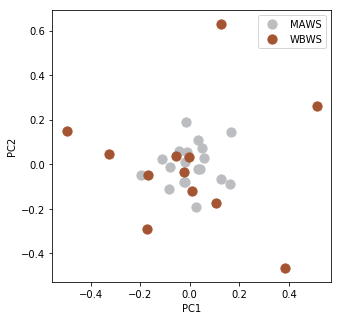

In [26]:
# Plotting the PCA
eigenvals = open('{0}/05__PopulationStructure/05b__smartPCA.output_unlink.pca.evec'.format(working_directory),'r')
eigenvals.readline()
maws_data = {'pc1':[], 'pc2':[]}
wbws_data = {'pc1':[], 'pc2':[]}
for l in eigenvals:
    i = l.strip().split()
    sp = i[0].split('_')[1]
    if sp == 'MAWS':
        maws_data['pc1'].append(float(i[1]))
        maws_data['pc2'].append(float(i[2]))
    elif sp == 'WBWS':
        wbws_data['pc1'].append(float(i[1]))
        wbws_data['pc2'].append(float(i[2]))
eigenvals.close()

fig = plt.figure(figsize=(5,5))
plt.scatter('pc1', 'pc2', c="#BBBDC0", s=85,label="MAWS", data=maws_data)
plt.scatter('pc1', 'pc2', c="#A45431", s=85,label="WBWS", data=wbws_data)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
fig.savefig('Figure__PCA_unlinkSNPs.pdf')
plt.show()

**STRUCTURE**

This is also the preparation for the files for STRUCTURE and plotting afterwards. STRUCTURE was run for 20 iterations for K=1 and K=2 and the runs were merged using CLUMPP.

In [28]:
#Create dictionary of of unique SNPs
infile = open('02e__alleleCounts_fixedinoutgroup_noSingletons_oneperlocus.txt','r')
infile.readline()
uniqSNPs = {}
for l in infile:
    i = l.strip().split()
    uniqSNPs[i[0][:-1]] = int(i[1])
infile.close()

infile = open('05a__genotypes_noLowMissingData.txt','r')

header = infile.readline().strip().split()
samples = header[3:35]

indiv_info = {}
for sample in samples:
    indiv_info[sample] = [[],[]]

for l in infile:
    i = l.strip().split()
    loc, pos = i[0][:-1], int(i[1])
    if loc in uniqSNPs and pos == uniqSNPs[loc]:  
        genos = i[3:35]
        for geno in enumerate(genos):
            if geno[1] == '0':
                indiv_info[samples[geno[0]]][0].append('0')
                indiv_info[samples[geno[0]]][1].append('0')
            elif geno[1] == '1':
                indiv_info[samples[geno[0]]][0].append('0')
                indiv_info[samples[geno[0]]][1].append('1')
            elif geno[1] == '2':
                indiv_info[samples[geno[0]]][0].append('1')
                indiv_info[samples[geno[0]]][1].append('1')
            elif geno[1] == '-':
                indiv_info[samples[geno[0]]][0].append('-9')
                indiv_info[samples[geno[0]]][1].append('-9')
infile.close()

In [29]:
outfile = open('17__structure.input.geno','w')
for sample in samples:
    sp = sample.split('_')[1]
    spN = '0' if sp == 'WBWS' else '1'
    outfile.write('{0}\t{1}\t{2}\n{0}\t{1}\t{3}\n'.format(sample, spN, '\t'.join(indiv_info[sample][0]), '\t'.join(indiv_info[sample][1])))
outfile.close()

In [32]:
## Plotting structure
p1 = []
p2 = []
samps = []
for l in open('{0}/05__PopulationStructure/05c-structure/17.2_K2.outfile'.format(working_directory),'r'):
    i = l.strip().split()
    p1.append(float(i[5]))
    p2.append(float(i[6]))

for l in open('{0}/05__PopulationStructure/05c-structure/17.2_K2.indivfile'.format(working_directory),'r'):
    i = l.strip().split()
    if len(i) == 0:
        break
    else:
        samps.append(i[1])

structure_dic = {'sample':samps, 'P1':p1, 'P2':p2}
structure_df = pd.DataFrame(structure_dic)

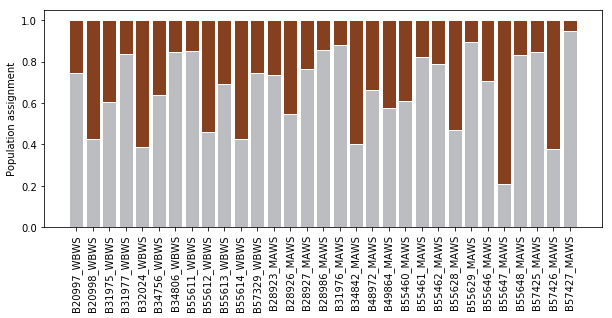

In [33]:
names=list(structure_df['sample'])
barWidth=0.85
plt.figure(figsize=(10,4))
plt.bar(list(structure_df['sample']),p1,color='#BBBDC0',edgecolor='white',width=barWidth)
plt.bar(list(structure_df['sample']),p2,bottom=p1,color='#854020',edgecolor='white',width=barWidth)
plt.xticks(structure_df['sample'],rotation='vertical')
plt.ylabel('Population assignment')
plt.savefig('Figure__STRUCTURE_run.pdf')

In [35]:
## Calculate likelihood
k1 = []
k2 = []
for l in open('{0}/05__PopulationStructure/05c-structure/17b__likelihoodK1.txt'.format(working_directory),'r'):
    i = l.strip().split()
    k1.append(float(i[-1]))
for l in open('{0}/05__PopulationStructure/05c-structure/17b__likelihoodK2.txt'.format(working_directory),'r'):
    i = l.strip().split()
    k2.append(float(i[-1]))
print('The mean log likelihood of K1 is {0} with a standard deviation of {1}'.format(sum(k1)/len(k1), statistics.stdev(k1)))
print('The mean log likelihood of K2 is {0} with a standard deviation of {1}'.format(sum(k2)/len(k2), statistics.stdev(k2)))

The mean log likelihood of K1 is -63104.34999999999 with a standard deviation of 23.98781488918747
The mean log likelihood of K2 is -78574.17000000001 with a standard deviation of 13503.698220238155


**DISTANCE NETWORK**

These blocks of scripts were used to generate a distance network to be input to SplitsTree.

In [36]:
infile = open('05a__genotypes_noLowMissingData.txt','r')
header = infile.readline().strip().split()
samples = header[3:]
genos = {}

for sample in samples:
    genos[sample] = {}

for l in infile:
    i = l.strip().split()
    loc = i[0]
    ind_genos = i[3:]
    for sample in enumerate(samples):
        if loc not in genos[sample[1]]:
            genos[sample[1]][loc] = [ind_genos[sample[0]]]
        elif loc in genos[sample[1]]:
            genos[sample[1]][loc].append(ind_genos[sample[0]])
infile.close()

# Remove missing loci
for sample in genos:
    locs = list(genos[sample].keys())
    for loc in locs:
        if '-' in genos[sample][loc]:
            genos[sample].pop(loc)

In [ ]:
## Calculate p-distances
div = {}
for sample in enumerate(samples):
    sample1 = sample[1]
    div[sample1] = {}
    for sample2 in samples[sample[0]:]:
        diffs = 0
        totLen = 0
        for locus in genos[sample1]:
            if locus in genos[sample2]:
                totLen += locus_lengths[locus]
                for allele in enumerate(genos[sample1][locus]):
                    diffs += abs(int(allele[1])-int(genos[sample2][locus][allele[0]]))
        div[sample1][sample2] = diffs/totLen

In [ ]:
## Output distance matrix
outfile = open('05d__distanceMatrix_uncorrectedPdist.txt','w')
samples = list(div.keys())
samples.sort()

for sample1 in samples:
    outfile.write('{0}'.format(sample1))
    for sample2 in samples:
        try:
            pdist = div[sample1][sample2]
        except KeyError:
            pdist = div[sample2][sample1]
        outfile.write('\t{0}'.format(pdist))
    outfile.write('\n')
outfile.close()

In [ ]:
## Output nexus file for splitstree
outfile = open('05d__distance_nexus.nexus','w')
samples = list(div.keys())
samples.sort()

outfile.write('#NEXUS\n\nBEGIN TAXA;\n\t\tDIMENSIONS NTAX={0};\n'.format(len(samples)))
outfile.write('TAXLABELS\n\t\t{0}\n;\nEND;\n\n'.format('\n\t\t'.join(samples)))
outfile.write('BEGIN DISTANCES;\n\t\tDIMENSIONS NTAX={0};\n\t\tFORMAT\n\t\tTRIANGLE=BOTH\n\t\tDIAGONAL\n\t\tLABELS\n\t\t'.format(len(samples)))
outfile.write(';\n\t\tMATRIX\n')
for sample1 in samples:
    outfile.write('\t\t{0}'.format(sample1))
    for sample2 in samples:
        try:
            pdist = div[sample1][sample2]
        except KeyError:
            pdist = div[sample2][sample1]
        outfile.write('\t{0}'.format(pdist))
    outfile.write('\n')
outfile.write('\t\t;\nEND;')
outfile.close()

In [38]:
## Now only do the loci with high chrZ
## This block was run after a later block that generated the 06a__fst_perchromosome.txt file. This can be run before using a different input file.
infile = open('05a__genotypes_noLowMissingData.txt','r')
header = infile.readline().strip().split()
samples = header[3:]
genos = {}

focal_loci = [] #chrZ only
for l in open('{0}/06a__fst_perchromosome.txt'.format(working_directory),'r'):
    i = l.strip().split()
    if i[1] == 'chrZ':
        focal_loci.append(i[0])


for sample in samples:
    genos[sample] = {}

for l in infile:
    i = l.strip().split()
    loc = i[0][:-1]
    if loc not in focal_loci:
        continue
    ind_genos = i[3:]
    for sample in enumerate(samples):
        if loc not in genos[sample[1]]:
            genos[sample[1]][loc] = [ind_genos[sample[0]]]
        elif loc in genos[sample[1]]:
            genos[sample[1]][loc].append(ind_genos[sample[0]])
infile.close()

# Remove missing loci
for sample in genos:
    locs = list(genos[sample].keys())
    for loc in locs:
        if '-' in genos[sample][loc]:
            genos[sample].pop(loc)

## Calculate p-distances
div = {}
for sample in enumerate(samples):
    sample1 = sample[1]
    div[sample1] = {}
    for sample2 in samples[sample[0]:]:
        diffs = 0
        totLen = 0
        for locus in genos[sample1]:
            if locus in genos[sample2]:
                totLen += locus_lengths[locus]
                for allele in enumerate(genos[sample1][locus]):
                    diffs += abs(int(allele[1])-int(genos[sample2][locus][allele[0]]))
        div[sample1][sample2] = diffs/totLen
        
## Output nexus file for splitstree
outfile = open('05d__distance_chrZ.nexus','w')
samples = list(div.keys())
samples.sort()

outfile.write('#NEXUS\n\nBEGIN TAXA;\n\t\tDIMENSIONS NTAX={0};\n'.format(len(samples)))
outfile.write('TAXLABELS\n\t\t{0}\n;\nEND;\n\n'.format('\n\t\t'.join(samples)))
outfile.write('BEGIN DISTANCES;\n\t\tDIMENSIONS NTAX={0};\n\t\tFORMAT\n\t\tTRIANGLE=BOTH\n\t\tDIAGONAL\n\t\tLABELS\n\t\t'.format(len(samples)))
outfile.write(';\n\t\tMATRIX\n')
for sample1 in samples:
    outfile.write('\t\t{0}'.format(sample1))
    for sample2 in samples:
        try:
            pdist = div[sample1][sample2]
        except KeyError:
            pdist = div[sample2][sample1]
        outfile.write('\t{0}'.format(pdist))
    outfile.write('\n')
outfile.write('\t\t;\nEND;')
outfile.close()

In [40]:
## Now only do the loci with high Fst in chr1A
infile = open('05a__genotypes_noLowMissingData.txt','r')
header = infile.readline().strip().split()
samples = header[3:]
genos = {}

focal_loci = ['1431','4302','27541','903','4390']
#focal_loci = ['1431','4302','903','291'] #high fst only

for sample in samples:
    genos[sample] = {}

for l in infile:
    i = l.strip().split()
    loc = i[0]
    if loc not in focal_loci:
        continue
    ind_genos = i[3:]
    for sample in enumerate(samples):
        if loc not in genos[sample[1]]:
            genos[sample[1]][loc] = [ind_genos[sample[0]]]
        elif loc in genos[sample[1]]:
            genos[sample[1]][loc].append(ind_genos[sample[0]])
infile.close()

# Remove missing loci
for sample in genos:
    locs = list(genos[sample].keys())
    for loc in locs:
        if '-' in genos[sample][loc]:
            genos[sample].pop(loc)

## Calculate p-distances
div = {}
for sample in enumerate(samples):
    sample1 = sample[1]
    div[sample1] = {}
    for sample2 in samples[sample[0]:]:
        diffs = 0
        totLen = 0
        for locus in genos[sample1]:
            if locus in genos[sample2]:
                totLen += locus_lengths[locus]
                for allele in enumerate(genos[sample1][locus]):
                    diffs += abs(int(allele[1])-int(genos[sample2][locus][allele[0]]))
            div[sample1][sample2] = diffs/totLen

## Output nexus file for splitstree
outfile = open('05d__distance_chr1Apeak_nexus.nexus','w')
samples = list(div.keys())
samples.sort()

outfile.write('#NEXUS\n\nBEGIN TAXA;\n\t\tDIMENSIONS NTAX={0};\n'.format(len(samples)))
outfile.write('TAXLABELS\n\t\t{0}\n;\nEND;\n\n'.format('\n\t\t'.join(samples)))
outfile.write('BEGIN DISTANCES;\n\t\tDIMENSIONS NTAX={0};\n\t\tFORMAT\n\t\tTRIANGLE=BOTH\n\t\tDIAGONAL\n\t\tLABELS\n\t\t'.format(len(samples)))
outfile.write(';\n\t\tMATRIX\n')
for sample1 in samples:
    outfile.write('\t\t{0}'.format(sample1))
    for sample2 in samples:
        try:
            pdist = div[sample1][sample2]
        except KeyError:
            pdist = div[sample2][sample1]
        outfile.write('\t{0}'.format(pdist))
    outfile.write('\n')
outfile.write('\t\t;\nEND;')
outfile.close()

## Population genetic parameters

**F<sub>ST</sub>**

In [42]:
infile = open('04a__alleleCounts_noLowMissingData_blastlocs_cormon.txt','r')
infile.readline()

FstN,FstD = [],[]
FstN_Z, FstD_Z = [],[]
for l in infile:
    i = l.strip().split()
    wbws, maws = i[3].split(','), i[4].split(',')
    nA,nB = int(wbws[0])+int(wbws[1]), int(maws[0])+int(maws[1])
    pA,pB = float(wbws[1])/nA, float(maws[1])/nB
    fstN = FstHudson_n(w=pA,x=pB,y=nA,z=nB)
    fstD = FstHudson_d(w=pA,x=pB,y=nA,z=nB)
    if len(i[0].split('_')) == 4:
        chrom = i[0].split('_')[2]
        if chrom == 'chrZ':
            FstN_Z.append(fstN)
            FstD_Z.append(fstD)
    else:
        FstN.append(fstN)
        FstD.append(fstD)

fA = sum(FstN)/len(FstN)
fAB = sum(FstD)/len(FstD)
print("Hudson's Fst (autosomal) is {0}".format(fA/fAB))
infile.close()

fA = sum(FstN_Z)/len(FstN_Z)
fAB = sum(FstD_Z)/len(FstD_Z)
print("Hudson's Fst (Z chromosome) is {0}".format(fA/fAB))
infile.close()

Hudson's Fst (autosomal) is 0.003882590695856589
Hudson's Fst (Z chromosome) is 0.00020523882990566874


In [43]:
## Find outliers by 0.995 quantile
chrom_data = {}
infile = open('06a__fst_perchromosome.txt','r')
infile.readline()
Fsts = []
for l in infile:
    i = l.strip().split()
    chrom, fst = i[1], float(i[3])
    Fsts.append(fst)
infile.close()

Fsts = numpy.array(Fsts)
print('The 0.995 quantile is {0}'.format(numpy.quantile(Fsts,0.995)))
print('The standard deviation is {0}'.format(statistics.stdev(Fsts)))

The 0.995 quantile is 0.11393561918824327
The standard deviation is 0.02539566362821785


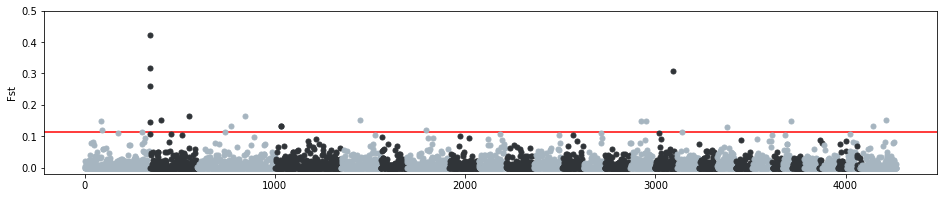

In [45]:
## Rename chromosomes and order based on zebrafinch homology and map the Fsts 

chrom_data = {}
chrom_rename = {}
rename_file = open('03c__chromosome_homology.txt','r')
rename_file.readline()
for l in rename_file:
    i = l.strip().split()
    chrom_rename[i[0]] = i[1]
infile = open('06a__fst_perchromosome.txt','r')
infile.readline()
Fsts = []
for l in infile:
    i = l.strip().split()
    chrom, fst = i[1], float(i[3])
    if fst < 0:
        fst = 0.0
    if chrom in chrom_rename:
        chrom = chrom_rename[chrom]
    if chrom not in chrom_data:
        chrom_data[chrom] = [fst]
    elif chrom in chrom_data:
        chrom_data[chrom].append(fst)
    Fsts.append(fst)
infile.close()

fig = plt.figure(figsize=(16,3))
chroms = list(chrom_data.keys())
chroms.sort()
start = 0
color = '#303438'
plt.axhline(y=numpy.quantile(Fsts,0.995), color='r', linestyle='-')
for chrom in chroms:
    color = '#a6b5c0' if color == '#303438' else '#303438'
    plt.plot(range(start,start+len(chrom_data[chrom])),chrom_data[chrom],'o',markersize=5,c=color)
    start += len(chrom_data[chrom])
plt.ylabel('Fst')
plt.ylim(-0.02,0.5)
plt.savefig('Fst_allchrom.pdf')

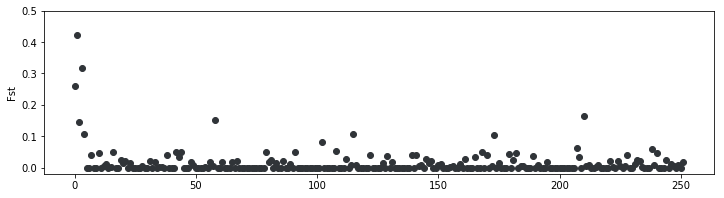

In [46]:
## Plot chr1A only

fig = plt.figure(figsize=(12,3))
color = '#303438' 
start=0
chrom='chr01A'
plt.plot(range(start,start+len(chrom_data[chrom])),chrom_data[chrom],'o',c=color)

plt.ylabel('Fst')
plt.ylim(-0.02,0.5)
plt.savefig('Figure__Fst_chr1A.pdf')

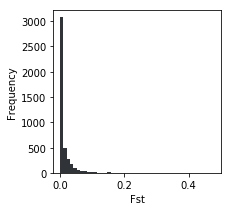

In [47]:
## Plot histogram

fig = plt.figure(figsize=(3,3))
Fst_array = numpy.asarray(Fsts)
plt.hist(Fst_array, bins=40, color='#303438')
plt.xlabel('Fst')
plt.ylabel('Frequency')
plt.xlim(-0.02,0.5)
plt.savefig('Figure__Fst_hist.pdf')

**D<sub>XY</sub>**

In [48]:
## Calculate total dxy
infile = open('04a__alleleCounts_noLowMissingData_blastlocs_cormon.txt','r')
infile.readline()


per_chrom = {}
per_locus = {}
for l in infile:
    i = l.strip().split()
    loc_info = i[0].split('_')
    locus = loc_info[0]
    wbws, maws = i[3].split(','), i[4].split(',')
    wbws_p = int(wbws[0])/(int(wbws[0])+int(wbws[1]))
    maws_p = int(maws[0])/(int(maws[0])+int(maws[1]))
    if locus not in per_locus:
        per_locus[locus] = [calcDxy(wbws_p,maws_p)]
    elif locus in per_locus:
        per_locus[locus].append(calcDxy(wbws_p,maws_p))
    if loc_info[1] != 'chrUnkn':
        chrom, pos = loc_info[2], int(loc_info[3])                                                                                                  
        if chrom not in per_chrom:
            per_chrom[chrom] = {pos:[locus]}
        if chrom in per_chrom:
            per_chrom[chrom][pos] = [locus]

# Data wide estimate
dxys_perloc = []
dxy_tot = 0
len_tot = 0
for locus in per_locus:
    loc_len = locus_lengths[locus]
    dxysum = sum(per_locus[locus])
    dxys_perloc.append(dxysum/loc_len)
    dxy_tot += dxysum
    len_tot += loc_len

# Per chrom estimate
for chrom in per_chrom:
    for pos in per_chrom[chrom]:
        locus = per_chrom[chrom][pos][0]
        loc_len = locus_lengths[locus]
        dxysum = sum(per_locus[locus])
        per_chrom[chrom][pos].append(dxysum/loc_len)

# Print it out
outfile = open('06b__dxy.txt','w')
outfile.write('chrom\tpos\t\tloc\tdxy\n')
chroms = list(per_chrom.keys())
chroms.sort()

for chrom in chroms:
    locs = list(per_chrom[chrom].keys())
    locs.sort()
    for loc in locs:
        info = [str(x) for x in per_chrom[chrom][loc]]
        outfile.write('{0}\t{1}\t{2}\n'.format(chrom,loc,'\t'.join(info)))
outfile.close()

In [49]:
## Calc dxy in different chromosome classes
dxy_auto = []
dxy_z = []
dxy_file = open('06b__dxy.txt','r')
dxy_file.readline()
for l in dxy_file:
    i = l.strip().split()
    if i[0] == 'chrZ':
        dxy_z.append(float(i[3]))
    else:
        dxy_auto.append(float(i[3]))
dxy_file.close()
print('Autosomal Dxy is {0}'.format(sum(dxy_auto)/len(dxy_auto)))
print('Z chromosome Dxy is {0}'.format(sum(dxy_z)/len(dxy_z)))

Autosomal Dxy is 0.012147436673059753
Z chromosome Dxy is 0.008124959628007114


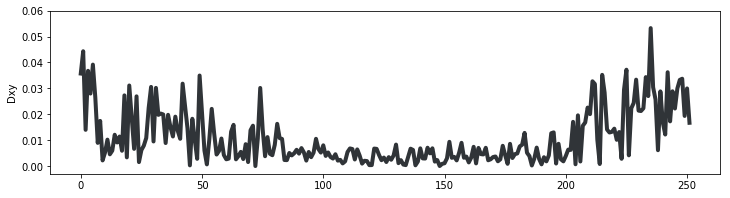

In [50]:
## Plot Dxy in chr1A

dxy_data = []
infile = open('06b__dxy.txt','r')
infile.readline()
for l in infile:
    i = l.strip().split()
    chrom, dxy = i[0], float(i[3])
    if chrom == 'chr4':
        dxy_data.append(dxy)
infile.close()

fig = plt.figure(figsize=(12,3))
start = 0

chrom = 'chr4'
color = '#303438' 
plt.plot(range(0,len(dxy_data)),dxy_data,'-',linewidth=4,c=color)
plt.ylim(-0.003,0.06)
plt.ylabel('Dxy')
plt.savefig('Figure__Dxy_chr1A.pdf')

In [54]:
## Plot the Fst outliers

outliers = ['1431','4302','903','50081']
fst_dict = {}
infile = open('06a__fst_perchromosome.txt','r')
infile.readline()
for l in infile:
    i = l.strip().split()
    fst = float(i[3])
    if fst < 0:
        fst = 0
    fst_dict[i[0]] = fst
infile.close()
fsts = []
dxys = []
fsts_out = []
dxys_out = []

infile = open('06b__dxy.txt','r')
infile.readline()
for l in infile:
    i = l.strip().split()
    if  i[2] in fst_dict:
        fsts.append(fst_dict[i[2]])
        dxys.append(float(i[3]))
        if i[2] in outliers:
            fsts_out.append(fst_dict[i[2]])
            dxys_out.append(float(i[3]))
infile.close()

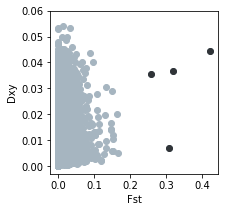

In [55]:
fig = plt.figure(figsize=(3,3))
plt.plot(fsts,dxys,'o',c='#a6b5c0')
plt.plot(fsts_out,dxys_out,'o',c="#303438")
plt.ylabel('Dxy')
plt.xlabel('Fst')
plt.ylim(-0.003,0.06)
plt.savefig('Figure__Dxy_Fst_allchrom_corr.pdf')

### $\theta_{\pi}$

Calculating the Tajima's theta ($\pi$) in these equations

In [63]:
## Calculate total pi
infile = open('04a__alleleCounts_noLowMissingData_blastlocs_cormon.txt','r')
infile.readline()


per_chrom_pi = {}
per_locus = {}
for l in infile:
    i = l.strip().split()
    loc_info = i[0].split('_')
    locus = loc_info[0]
    wbws, maws, duws = i[3].split(','), i[4].split(','), i[5].split(',')
    bfws, liws, wbre = i[6].split(','), i[7].split(','), i[8].split(',')
    wbws_p = int(wbws[0])/(int(wbws[0])+int(wbws[1]))
    maws_p = int(maws[0])/(int(maws[0])+int(maws[1]))
    duws_p = int(duws[0])/(int(duws[0])+int(duws[1]))
    bfws_p = int(bfws[0])/(int(bfws[0])+int(bfws[1]))
    liws_p = int(liws[0])/(int(liws[0])+int(liws[1]))
    wbre_p = int(wbre[0])/(int(wbre[0])+int(wbre[1]))
    if locus not in per_locus:
        per_locus[locus] = {'wbws':[calcPi(wbws_p,(int(wbws[0])+int(wbws[1])))],
                            'maws':[calcPi(maws_p,(int(maws[0])+int(maws[1])))],
                            'duws':[calcPi(duws_p,(int(duws[0])+int(duws[1])))],
                            'bfws':[calcPi(bfws_p,(int(bfws[0])+int(bfws[1])))],
                            'liws':[calcPi(liws_p,(int(liws[0])+int(liws[1])))],
                            'wbre':[calcPi(wbre_p,(int(wbre[0])+int(wbre[1])))]}
    elif locus in per_locus:
        per_locus[locus]['wbws'].append(calcPi(wbws_p,(int(wbws[0])+int(wbws[1]))))
        per_locus[locus]['maws'].append(calcPi(maws_p,(int(maws[0])+int(maws[1]))))
        per_locus[locus]['duws'].append(calcPi(duws_p,(int(duws[0])+int(duws[1]))))
        per_locus[locus]['bfws'].append(calcPi(bfws_p,(int(bfws[0])+int(bfws[1]))))
        per_locus[locus]['liws'].append(calcPi(liws_p,(int(liws[0])+int(liws[1]))))
        per_locus[locus]['wbre'].append(calcPi(wbre_p,(int(wbre[0])+int(wbre[1]))))
    if loc_info[1] != 'chrUnkn':
        chrom, pos = loc_info[2], int(loc_info[3])                                                                                                  
        if chrom not in per_chrom_pi:
            per_chrom_pi[chrom] = {pos:[locus]}
        if chrom in per_chrom_pi:
            per_chrom_pi[chrom][pos] = [locus]

In [64]:
# Data wide estimate
spp = ['wbws','maws','duws','bfws','liws','wbre']
pi_perloc = [[],[],[],[],[],[]]
pi_tot = [0,0,0,0,0,0]
len_tot = 0
for locus in per_locus:
    loc_len = locus_lengths[locus]
    for sp in enumerate(spp):
        pisum = sum(per_locus[locus][sp[1]])
        pi_perloc[sp[0]].append(pisum/loc_len)
        pi_tot[sp[0]] += pisum
    len_tot += loc_len

# Per chrom estimate
for chrom in per_chrom_pi:
    for pos in per_chrom_pi[chrom]:
        locus = per_chrom_pi[chrom][pos][0]
        loc_len = locus_lengths[locus]
        for sp in enumerate(spp):
            pisum = sum(per_locus[locus][sp[1]])
            per_chrom_pi[chrom][pos].append(pisum/loc_len)

In [67]:
outfile = open('06c__theta_pi.txt','w')
outfile.write('chrom\tpos\t\tloc\t{0}\n'.format('\t'.join(spp)))
chroms = list(per_chrom_pi.keys())
chroms.sort()

for chrom in chroms:
    locs = list(per_chrom_pi[chrom].keys())
    locs.sort()
    for loc in locs:
        info = [str(x) for x in per_chrom_pi[chrom][loc]]
        outfile.write('{0}\t{1}\t{2}\n'.format(chrom,loc,'\t'.join(info)))
outfile.close()

In [68]:
for sp in enumerate(spp):
    print('Global pi in {0} is {1}'.format(sp[1], pi_tot[sp[0]]/len_tot))

Global pi in wbws is 0.012326563644488031
Global pi in maws is 0.012354249514892942
Global pi in duws is 0.0048503193345181194
Global pi in bfws is 0.006980731998513236
Global pi in liws is 0.00405654582706516
Global pi in wbre is 0.0036017222781074944


In [69]:
## Calc pi for different chromosomes
pi_auto_maws, pi_auto_wbws = [], []
pi_z_maws, pi_z_wbws = [], []
pi_file = open('06c__theta_pi.txt','r')
pi_file.readline()
for l in pi_file:
    i = l.strip().split()
    if i[0] == 'chrZ':
        pi_z_wbws.append(float(i[3]))
        pi_z_maws.append(float(i[4]))
    else:
        pi_auto_wbws.append(float(i[3]))
        pi_auto_maws.append(float(i[4]))
pi_file.close()

print('Autosomal MAWS pi is: {0}'.format(sum(pi_auto_maws)/len(pi_auto_maws)))
print('Z chromosome MAWS pi is: {0}'.format(sum(pi_z_maws)/len(pi_z_maws)))
print('Autosomal MAWS pi is: {0}'.format(sum(pi_auto_wbws)/len(pi_auto_wbws)))
print('Autosomal WBWS pi is: {0}'.format(sum(pi_z_wbws)/len(pi_z_wbws)))

Autosomal MAWS pi is: 0.012085160213073518
Z chromosome MAWS pi is: 0.007943551803610338
Autosomal MAWS pi is: 0.01203195307178845
Autosomal WBWS pi is: 0.008286979025027973


Text(0, 0.5, 'Pi')

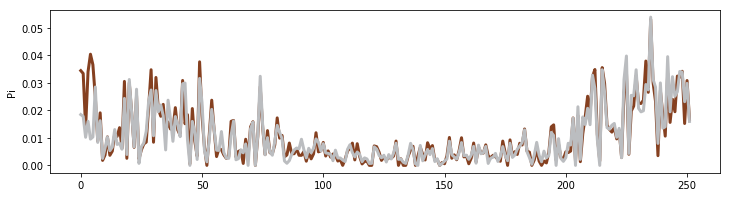

In [71]:
## Plot pi across chr1A

theta_wbws = []
theta_maws = []
theta_wbws_out = []
theta_maws_out = []
infile = open('06c__theta_pi.txt','r')
infile.readline()
for l in infile:
    i = l.strip().split()
    chrom, tWBWS, tMAWS = i[0], float(i[3]), float(i[4])
    if chrom == 'chr4':
        theta_wbws.append(tWBWS)
        theta_maws.append(tMAWS)
        if i[2] in outliers:
            theta_wbws_out.append(tWBWS)
            theta_maws_out.append(tMAWS)
infile.close()

fig = plt.figure(figsize=(12,3))
start = 0

chrom = 'chr4'
plt.plot(range(0,len(theta_wbws)),theta_wbws,'-',linewidth=3,c="#854020")
plt.plot(range(0,len(theta_maws)),theta_maws,'-',linewidth=3,c="#BBBDC0")

plt.ylabel('Pi')

Text(0, 0.5, 'Pi WBWS')

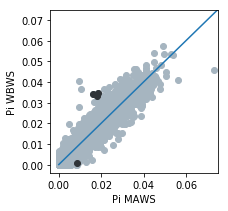

In [72]:
theta_wbws = []
theta_maws = []
theta_wbws_out = []
theta_maws_out = []

outliers = ['1431','4302','903','50081']

infile = open('06c__theta_pi.txt','r')
infile.readline()
for l in infile:
    i = l.strip().split()
    chrom, tWBWS, tMAWS = i[0], float(i[3]), float(i[4])
    theta_wbws.append(tWBWS)
    theta_maws.append(tMAWS)
    if i[2] in outliers:
        theta_wbws_out.append(tWBWS)
        theta_maws_out.append(tMAWS)
infile.close()


x = numpy.linspace(0, 10, 1000)
fig = plt.figure(figsize=(3,3))
plt.plot(theta_maws,theta_wbws,'o',c='#a6b5c0')
plt.plot(theta_maws_out,theta_wbws_out,'o',c="#303438")
plt.plot(x,x,linestyle='-')
plt.xlim(-0.004,0.075)
plt.ylim(-0.004,0.075)
plt.xlabel('Pi MAWS')
plt.ylabel('Pi WBWS')


### $\theta_{W}$

Calculating the Watterson's theta in these equations

In [73]:
## Calculate total theta
infile = open('04a__alleleCounts_noLowMissingData_blastlocs_cormon.txt','r')
infile.readline()

spp = ['wbws','maws','duws','bfws','liws','wbre']

per_chrom = {}
per_locus_theta = {}
for l in infile:
    i = l.strip().split()
    loc_info = i[0].split('_')
    locus = loc_info[0]
    allele_dir = {'wbws':i[3].split(','),
                  'maws':i[4].split(','),
                  'duws':i[5].split(','),
                  'bfws':i[6].split(','),
                  'liws':i[7].split(','),
                  'wbre':i[8].split(',')}
    if locus not in per_locus_theta:
        per_locus_theta[locus] = {}
        for sp in spp:
            per_locus_theta[locus][sp] = [0,int(allele_dir[sp][0])+int(allele_dir[sp][1])]
            if '0' in allele_dir[sp]:
                continue
            else:
                per_locus_theta[locus][sp][0] += 1
    elif locus in per_locus_theta:
        for sp in spp:
            if '0' in allele_dir[sp]:
                continue
            else:
                per_locus_theta[locus][sp][0] += 1
    if loc_info[1] != 'chrUnkn':
        chrom, pos = loc_info[2], int(loc_info[3])                                                                                                  
        if chrom not in per_chrom:
            per_chrom[chrom] = {pos:[locus]}
        if chrom in per_chrom:
            per_chrom[chrom][pos] = [locus]

In [74]:
# Data wide estimate
spp = ['wbws','maws','duws','bfws','liws','wbre']
theta_perloc = [[],[],[],[],[],[]]
theta_tot = [0,0,0,0,0,0]
len_tot = 0
for locus in per_locus_theta:
    loc_len = locus_lengths[locus]
    for sp in enumerate(spp):
        theta = calcTheta(per_locus_theta[locus][sp[1]][0],per_locus_theta[locus][sp[1]][1])
        theta_perloc[sp[0]].append(theta/loc_len)
        theta_tot[sp[0]] += theta
    len_tot += loc_len

# Per chrom estimate
for chrom in per_chrom:
    for pos in per_chrom[chrom]:
        locus = per_chrom[chrom][pos][0]
        loc_len = locus_lengths[locus]
        for sp in enumerate(spp):
            theta = calcTheta(per_locus_theta[locus][sp[1]][0],per_locus_theta[locus][sp[1]][1])
            per_chrom[chrom][pos].append(theta/loc_len)

In [75]:
for sp in enumerate(spp):
    print('Global theta in {0} is {1}'.format(sp[1], theta_tot[sp[0]]/len_tot))

Global theta in wbws is 0.01758043384018677
Global theta in maws is 0.019912232000514882
Global theta in duws is 0.004870234654851241
Global theta in bfws is 0.0071808383430655666
Global theta in liws is 0.004150857028604678
Global theta in wbre is 0.0036044257405270287


In [77]:
outfile = open('06d__theta_watterson.txt','w')
outfile.write('chrom\tpos\t\tloc\t{0}\n'.format('\t'.join(spp)))
chroms = list(per_chrom.keys())
chroms.sort()

for chrom in chroms:
    locs = list(per_chrom[chrom].keys())
    locs.sort()
    for loc in locs:
        info = [str(x) for x in per_chrom[chrom][loc]]
        outfile.write('{0}\t{1}\t{2}\n'.format(chrom,loc,'\t'.join(info)))
        
outfile.close()

In [78]:
pi_auto_maws, pi_auto_wbws = [], []
pi_z_maws, pi_z_wbws = [], []
pi_file = open('06d__theta_watterson.txt','r')
pi_file.readline()
for l in pi_file:
    i = l.strip().split()
    if i[0] == 'chrZ':
        pi_z_wbws.append(float(i[3]))
        pi_z_maws.append(float(i[4]))
    else:
        pi_auto_wbws.append(float(i[3]))
        pi_auto_maws.append(float(i[4]))
pi_file.close()
print('Autosomal MAWS theta is: {0}'.format(sum(pi_auto_maws)/len(pi_auto_maws)))
print('Z chromosome MAWS theta is: {0}'.format(sum(pi_z_maws)/len(pi_z_maws)))
print('Autosomal WBWS pi is: {0}'.format(sum(pi_auto_wbws)/len(pi_auto_wbws)))
print('Autosomal WBWS pi is: {0}'.format(sum(pi_z_wbws)/len(pi_z_wbws)))

Autosomal MAWS theta is: 0.01964112284691597
Z chromosome MAWS theta is: 0.012964453072536188
Autosomal WBWS pi is: 0.017267151241805005
Autosomal WBWS pi is: 0.012060394476898186


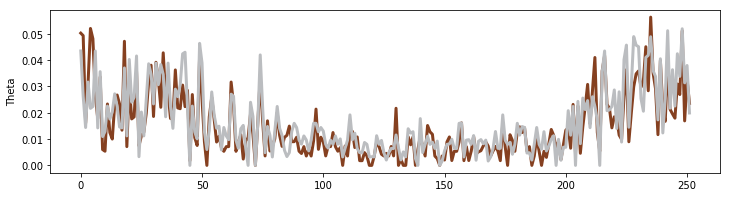

In [79]:
## Plotting theta across chr1A
theta_wbws = []
theta_maws = []
infile = open('06d__theta_watterson.txt','r')
theta_wbws_out = []
theta_maws_out = []
outliers = ['1431','4302','903','50081']
infile.readline()
for l in infile:
    i = l.strip().split()
    chrom, tWBWS, tMAWS = i[0], float(i[3]), float(i[4])
    if chrom == 'chr4':
        theta_wbws.append(tWBWS)
        theta_maws.append(tMAWS)
        if i[2] in outliers:
            theta_wbws_out.append(tWBWS)
            theta_maws_out.append(tMAWS)
infile.close()

fig = plt.figure(figsize=(12,3))
start = 0

chrom = 'chr4'
plt.plot(range(0,len(theta_wbws)),theta_wbws,'-',linewidth=3,c="#854020")
plt.plot(range(0,len(theta_maws)),theta_maws,'-',linewidth=3,c="#BBBDC0")

plt.ylabel('Theta')
plt.savefig('Figure__Theta_chr04.pdf')

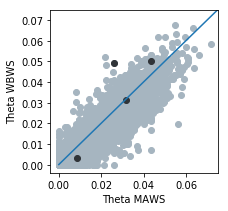

In [80]:
theta_wbws = []
theta_maws = []
theta_wbws_out = []
theta_maws_out = []

outliers = ['1431','4302','903','50081']

infile = open('06d__theta_watterson.txt','r')
infile.readline()
for l in infile:
    i = l.strip().split()
    chrom, tWBWS, tMAWS = i[0], float(i[3]), float(i[4])
    theta_wbws.append(tWBWS)
    theta_maws.append(tMAWS)
    if i[2] in outliers:
        theta_wbws_out.append(tWBWS)
        theta_maws_out.append(tMAWS)
infile.close()



fig = plt.figure(figsize=(3,3))
plt.plot(theta_maws,theta_wbws,'o',c='#a6b5c0')
plt.plot(theta_maws_out,theta_wbws_out,'o',c="#303438")
plt.plot(x,x,linestyle='-')
plt.ylim(-0.004,0.075)
plt.xlim(-0.004,0.075)
plt.xlabel('Theta MAWS')
plt.ylabel('Theta WBWS')
plt.savefig('Figure__Theta_wholegenome.pdf')

### Tajima's D

In [81]:
spp = ['wbws','maws','duws','bfws','liws','wbre']
per_chrom_tD = {}

for chrom in per_chrom_pi:
    per_chrom_tD[chrom] = {}
    for pos in per_chrom_pi[chrom]:
        loc = per_chrom_pi[chrom][pos][0]
        per_chrom_tD[chrom][pos] = [loc]
        for sp in enumerate(spp):
            pi = per_chrom_pi[chrom][pos][sp[0]+1]
            S = per_locus_theta[loc][sp[1]][0]
            n = per_locus_theta[loc][sp[1]][1]
            loc_len = locus_lengths[loc]
            per_chrom_tD[chrom][pos].append(TajimasD(pi*loc_len,S,n))

In [82]:
# Data wide estimate
spp = ['wbws','maws','duws','bfws','liws','wbre']
tD_perloc = [[],[],[],[],[],[]]

for chrom in per_chrom_tD:
     for pos in per_chrom_tD[chrom]:
            for sp in range(6):
                tD = per_chrom_tD[chrom][pos][sp+1]
                tD_perloc[sp].append(tD)

In [84]:
for sp in enumerate(spp):
    print('Global Tajimas D in {0} is {1}'.format(sp[1], sum(tD_perloc[sp[0]])/len(tD_perloc[sp[0]])))

Global Tajimas D in wbws is -0.9493761030452419
Global Tajimas D in maws is -1.1425427453207573
Global Tajimas D in duws is -0.04793629214323333
Global Tajimas D in bfws is -0.12801828024328385
Global Tajimas D in liws is -0.07874175219276522
Global Tajimas D in wbre is -0.02338707488472833


In [85]:
outfile = open('06e__TajimasD.txt','w')
outfile.write('chrom\tpos\t\tloc\t{0}\n'.format('\t'.join(spp)))
chroms = list(per_chrom_tD.keys())
chroms.sort()

for chrom in chroms:
    locs = list(per_chrom_tD[chrom].keys())
    locs.sort()
    for loc in locs:
        info = [str(x) for x in per_chrom_tD[chrom][loc]]
        outfile.write('{0}\t{1}\t{2}\n'.format(chrom,loc,'\t'.join(info)))
        
outfile.close()

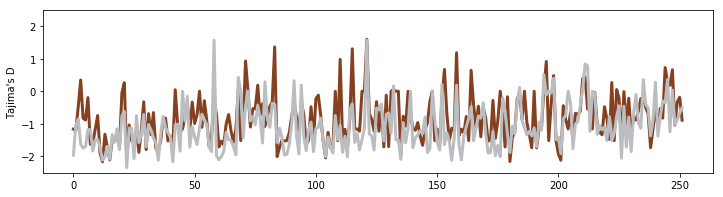

In [86]:
tD_wbws = []
tD_maws = []
tD_wbws_out = []
tD_maws_out = []
outliers = ['1431','4302','903','291']
infile = open('06e__TajimasD.txt','r')
infile.readline()
for l in infile:
    i = l.strip().split()
    chrom, tWBWS, tMAWS = i[0], float(i[3]), float(i[4])
    if chrom == 'chr4':
        tD_wbws.append(tWBWS)
        tD_maws.append(tMAWS)
        if i[2] in outliers:
            tD_wbws_out.append(tWBWS)
            tD_maws_out.append(tMAWS)
infile.close()

fig = plt.figure(figsize=(12,3))
start = 0

chrom = 'chr4'
plt.plot(range(0,len(tD_wbws)),tD_wbws,'-',linewidth=3,c="#854020")
plt.plot(range(0,len(tD_maws)),tD_maws,'-',linewidth=3,c="#BBBDC0")
plt.ylim(-2.5,2.5)
plt.ylabel("Tajima's D")
plt.savefig('Figure__TajimasD_chr1A.pdf')

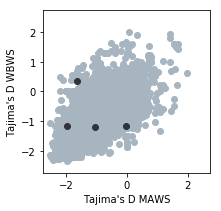

In [87]:
tD_wbws = []
tD_maws = []
tD_wbws_out = []
tD_maws_out = []
outliers = ['1431','4302','903','50081']
infile = open('06e__TajimasD.txt','r')
infile.readline()
for l in infile:
    i = l.strip().split()
    chrom, tWBWS, tMAWS = i[0], float(i[3]), float(i[4])
    tD_wbws.append(tWBWS)
    tD_maws.append(tMAWS)
    if i[2] in outliers:
        tD_wbws_out.append(tWBWS)
        tD_maws_out.append(tMAWS)
infile.close()


fig = plt.figure(figsize=(3,3))
plt.plot(tD_maws,tD_wbws,'o',c='#a6b5c0')
plt.plot(tD_maws_out,tD_wbws_out,'o',c="#303438")
plt.xlabel("Tajima's D MAWS")
plt.ylabel("Tajima's D WBWS")
plt.xlim(-2.75,2.75)
plt.ylim(-2.75,2.75)
plt.savefig('Figure__TajimasD_allchrom_corr.pdf')

In [89]:
pi_auto_maws, pi_auto_wbws = [], []
pi_z_maws, pi_z_wbws = [], []
pi_file = open('06e__TajimasD.txt','r')
pi_file.readline()
for l in pi_file:
    i = l.strip().split()
    if i[0] == 'chrZ':
        pi_z_wbws.append(float(i[3]))
        pi_z_maws.append(float(i[4]))
    else:
        pi_auto_wbws.append(float(i[3]))
        pi_auto_maws.append(float(i[4]))
pi_file.close()
print('Autosomal MAWS Tajimas D is: {0}'.format(sum(pi_auto_maws)/len(pi_auto_maws)))
print('Z chromosome MAWS Tajimas D is: {0}'.format(sum(pi_z_maws)/len(pi_z_maws)))
print('Autosomal WBWS Tajimas D is: {0}'.format(sum(pi_auto_wbws)/len(pi_auto_wbws)))
print('Z chromosome WBWS Tajimas D is: {0}'.format(sum(pi_z_wbws)/len(pi_z_wbws)))

Autosomal MAWS Tajimas D is: -1.1426476974741566
Z chromosome MAWS Tajimas D is: -1.1402394405349632
Autosomal WBWS Tajimas D is: -0.9489402616157038
Z chromosome WBWS Tajimas D is: -0.9589411821601779


## Fst outliers

In [91]:
## Find outliers (note this has not been renamed with the zebrafinch chromosome nomenclature)
outliers = []
chrom_data = {}
infile = open('06a__fst_perchromosome.txt','r')
infile.readline()
Fsts = []
for l in infile:
    i = l.strip().split()
    chrom, fst = i[1], float(i[3])
    if fst > 0.114:
        outliers.append(i[0])
        print(l)
    Fsts.append(fst)
infile.close()

Fsts = numpy.array(Fsts)

652	chr1	48486616	0.11425491781191052

50047	chr1	64757283	0.1335540838852097

3490	chr1	99730082	0.16531895777178793

379	chr15	6376850	0.14928167877320428

182028	chr15	9938294	0.146956803255943

50081	chr16	14936576	0.30927835051546393

4	chr19	7844670	0.1277777777777778

2339	chr2	26674465	0.14882005899705017

101835	chr2	28959694	0.12000000000000001

6381	chr27	4558118	0.14824831592918133

73702	chr3	2566947	0.1322197748409203

72863	chr3	2670660	0.13129472019281463

1431	chr4	696288	0.2592456075684971

4302	chr4	866717	0.4221864828473121

27541	chr4	1120584	0.14586841284689747

903	chr4	1364901	0.31884344110461554

182049	chr4	14689166	0.15227228014951805

227379	chr4	70703725	0.16357047611577374

6774	chr5	30405173	0.15285285285285283

548	chr6	23990180	0.1199040767386091

889	chrZ	24744084	0.1326392905340274

24858	chrZ	53562241	0.15285168508664213



In [ ]:
## Make a directory with coordinate range 40kb upstream and downstream from the outliers 
infile = open('06a__fst_perchromosome.txt','r')
infile.readline()
outliers = {}
dist = 40000
for l in infile:
    i = l.strip().split()
    if float(i[3]) > 0.114:
        if i[1] not in outliers:
            outliers[i[1]] = [[int(i[2]) - dist, int(i[2]) + dist]]
        elif i[1] in outliers:
            start, end = int(i[2]) - dist, int(i[2]) + dist
            outliers[i[1]].append([start,end])
infile.close()

outliers['chr4'].append([696288-dist,1364901+dist])

In [93]:
outfile = open('07b__genesbyoutliers_40kb_chr1Aextended.txt','w')
for l in open('{0}/07__FstOutlier/07b__Corvus_moneduloides-GCA_009650955.1-2020_08-genes.gff3'.format(working_directory),'r'):
    if l.startswith('#'):
        continue
    else:
        i = l.strip().split()
        chrom = 'chr' + i[0]
        if chrom in outliers:
            start, end = int(i[3]), int(i[4])
            for window in outliers[chrom]:
                if start > window[0] and end < window[1] and i[2] == 'gene':
                    outfile.write(l)
outfile.close()

In [95]:
## Calculating genes per outlier
dists = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
genes = []

for dist in dists:
    count = 0
    infile = open('06a__fst_perchromosome.txt','r')
    infile.readline()
    outliers = {}
    for l in infile:
        i = l.strip().split()
        if float(i[3]) > 0.114:
            if i[1] not in outliers:
                outliers[i[1]] = [[int(i[2]) - dist, int(i[2]) + dist]]
            elif i[1] in outliers:
                start, end = int(i[2]) - dist, int(i[2]) + dist
                outliers[i[1]].append([start,end])
    infile.close()
    outliers['chr4'].append([696288-dist,1364901+dist])
    for l in open('{0}/07__FstOutlier/07b__Corvus_moneduloides-GCA_009650955.1-2020_08-genes.gff3'.format(working_directory),'r'):
        if l.startswith('#'):
            continue
        else:
            i = l.strip().split()
            chrom = 'chr' + i[0]
            if chrom in outliers:
                start, end = int(i[3]), int(i[4])
                for window in outliers[chrom]:
                    if start > window[0] and end < window[1] and i[2] == 'gene':
                        count += 1
    genes.append(count/22)

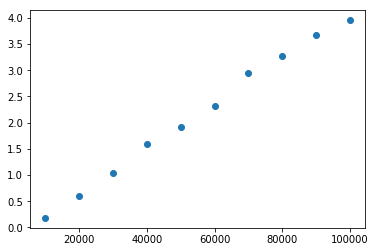

In [96]:
## Plot gene number depending on distance from outlier. Choose conservative one which recovers at least one gene
plt.plot(dists,genes,'o')

## Demographic modeling
Preparing the input for fastsimcoal2 and analyzing the output.

In [97]:
## Generating SFS
# because we have three outgroups, we can do an unfolded 2DSFS
sfs = [[0 for col in range(41)] for row in range(29)]
# Getting alleles
fixed_loci = {}
infile = open('02f__alleleCounts_fixedinoutgroup_oneperlocus.txt','r')
infile.readline()
for l in infile:
    i = l.strip().split()
    der_wbws, der_maws = int(i[3].split(',')[1]),int(i[4].split(',')[1])
    sfs[der_wbws][der_maws] += 1
infile.close()

Text(0.5, 15.0, 'MAWS alleles')

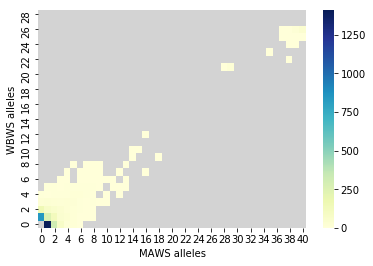

In [98]:
cmap_reds = plt.get_cmap('YlGnBu')
num_colors=1332
colors = ['lightgrey'] + [cmap_reds(i / num_colors) for i in range(2,num_colors)]
cmap = LinearSegmentedColormap.from_list('', colors, num_colors)
ax = sns.heatmap(sfs,cmap=cmap,vmin=1)
ax.invert_yaxis()
plt.ylabel('WBWS alleles')
plt.xlabel('MAWS alleles')

In [99]:
# Create a list of loci to omit

omit = set()
infile = open('04a__alleleCounts_noLowMissingData_blastlocs_cormon.txt','r')
infile.readline()
for l in infile:
    i = l.strip().split()
    loc_i = i[0].split('_')
    if len(loc_i) == 2:
        continue
    elif loc_i[2] == 'chrZ':
        omit.add(loc_i[0])
infile.close()
infile = open('06a__fst_perchromosome.txt','r')
infile.readline()
for l in infile:
    i = l.strip().split()
    if float(i[3]) > 0.114:
        omit.add(i[0])
infile.close()

In [100]:
## Generating 50 bootstrapped SFS by sampling a different SNP per cluster
# Only autosomal and no outlier loci
for num in range(1,51):
    sfs = [[0 for col in range(41)] for row in range(29)]
    infile = open('02a__alleleCounts_fixedinoutgroup.txt','r')
    infile.readline()
    loci = {}
    for l in infile:
        i = l.strip().split()
        locus = i[0]
        if locus in omit:
            continue
        elif locus not in loci:
            loci[locus] = {i[1]:[i[2],i[3],i[4]]}
        elif locus in loci:
            loci[locus][i[1]] = [i[2],i[3],i[4]]
    for locus in loci:
        snps = list(loci[locus].keys())
        nsnps = len(snps)
        pickedsnp = snps[random.randrange(nsnps)-1]
        der_wbws, der_maws = int(loci[locus][pickedsnp][1].split(',')[1]),int(loci[locus][pickedsnp][2].split(',')[1])
        sfs[der_wbws][der_maws] += 1
    infile.close()
    
    outfile = open('{0}/08__demographicmodeling/bootstrap_sfs/boot{1}_jointDAFpop1_0.obs'.format(working_directory,num),'w')
    outfile.write('1 observations\n')
    outfile.write('\t')
    for j in range(len(sfs[0])):
        outfile.write('\td0_{0}'.format(j))
    outfile.write('\n')
    for fs in enumerate(sfs):
        outfile.write('d1_{0}\t{1}\n'.format(fs[0],'\t'.join([str(x) for x in fs[1]])))
    outfile.close()

FileNotFoundError: [Errno 2] No such file or directory: '08__demographicmodeling/bootstrap_sfs/boot1_jointDAFpop1_0.obs'

In [101]:
## Gather the log likelihood measurements
models = ['panmixia','recent_divergence','isolation_with_migration','secondary_contact','change_migration']
model_abbrev = ['rd','rd','im','sc','changeM']
dm_dir = '/home/jpenalba/Dropbox/Research/Woodswallows/WOSW.fasta_files/1-add_species/00-final_analyses/08__demographicmodeling'
num_params = [3,4,6,7,9]
aics = {'Model':[],'AIC':[],'boot':[]}
aics_calc = {}
for model in enumerate(models):
    aics_calc[model[1]] = []
    for boot in range(1,11):
        infile = open('{0}/{1}/bootstrap_sfs/boot{2}/bestrun/{3}.bestlhoods'.format(dm_dir,model[1],boot,model_abbrev[model[0]]),'r')
        infile.readline()
        i = infile.readline().strip().split()
        llhood = float(i[-2])
        infile.close()
        aics['Model'].append(model[1])
        aics['AIC'].append(calcAIC(llhood,num_params[model[0]]))
        aics_calc[model[1]].append(calcAIC(llhood,num_params[model[0]]))
        aics['boot'].append(boot)

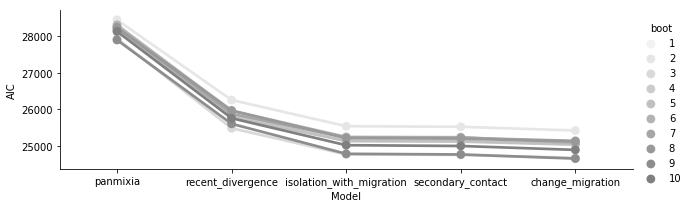

In [102]:
# Plot AIC values
aics = pd.DataFrame(aics)

sns.catplot(x="Model", y="AIC", hue="boot",kind="point", data=aics, color='grey',height=3,aspect=3)
plt.savefig('Figure__demographicModelAIC.pdf')

In [103]:
# AIC values across the different bootstrapped SFS
aics_calc = pd.DataFrame(aics_calc)
aics_calc

,panmixia,recent_divergence,isolation_with_migration,secondary_contact,change_migration
0,28275.259684,25987.730344,25231.946373,25235.226610,25063.774238
1,28455.312621,26259.329455,25542.454565,25525.909545,25423.995241
2,27939.478319,25486.798373,24768.394566,24756.965891,24672.311763
3,28191.265989,25849.469326,25135.882527,25118.665152,25034.683380
4,28175.299864,25782.588442,25140.510723,25135.183897,25046.942342
5,28316.365432,25962.314411,25247.567109,25240.992283,25082.397546
6,28245.496471,25880.678563,25228.920776,25225.302469,25140.450319
7,28244.492544,25970.649769,25215.441444,25202.801608,25124.521036
8,27903.898776,25607.255805,24785.714611,24767.921590,24655.203557
9,28137.542076,25760.506652,25021.637470,25000.247811,24893.240188


In [105]:
## Getting parameter estimates for secondary contact
sc_params = {'NPOP1':[],'NPOP2':[],'NANC':[],'MIG1':[],'MIG2':[],'TSC':[],'TDIV':[],'MaxEstLhood':[],'boot':[]}
for boot in range(1,51):
        infile = open('{0}/secondary_contact/bootstrap_parameterEstimation/boot{2}/bestrun/sc.bestlhoods'.format(dm_dir,model[1],boot,model_abbrev[model[0]]),'r')
        header = infile.readline().strip().split()
        values = infile.readline().strip().split()
        for j in range(8):
            sc_params[header[j]].append(values[j])
        sc_params['boot'].append(boot)

In [107]:
## Print effective population sizes
print('Ancestral population size: {0}+-{1}'.format(sum([int(x) for x in sc_params['NANC']])/len([int(x) for x in sc_params['NANC']]),statistics.stdev([int(x) for x in sc_params['NANC']])))
print('MAWS population size: {0}+-{1}'.format(sum([int(x) for x in sc_params['NPOP1']])/len([int(x) for x in sc_params['NPOP1']]),statistics.stdev([int(x) for x in sc_params['NPOP1']])))
print('WBWS population size: {0}+-{1}'.format(sum([int(x) for x in sc_params['NPOP2']])/len([int(x) for x in sc_params['NPOP2']]),statistics.stdev([int(x) for x in sc_params['NPOP2']])))


Ancestral population size: 645623.16+-1291178.0955883022
MAWS population size: 2759701.02+-4403203.8004427
WBWS population size: 4837709.94+-10525763.383080686


In [109]:
## Print migration rates
mig_rates = {'MIG':[],'Migration rate':[],'boot':[],'colors':[]}
mig_params = {'MIG1':[],'MIG2':[]}
migs = ['MIG1','MIG2']
pops = ['NPOP1','NPOP2']
my_pal = {'MIG1':'#BBBDC0','MIG2':'#854020'}
for mig in enumerate(migs):
    for rate in enumerate(sc_params[mig[1]]):
        mig_rates['MIG'].append(mig[1])
        mig_rates['Migration rate'].append(float(rate[1])*float(sc_params[pops[mig[0]]][rate[0]]))
        mig_params[mig[1]].append(float(rate[1])*float(sc_params[pops[mig[0]]][rate[0]]))
        mig_rates['boot'].append(sc_params['boot'][rate[0]])
        mig_rates['colors'].append(my_pal[mig[1]])
mig_rates = pd.DataFrame(mig_rates)

mig1_med = statistics.median([float(x) for x in mig_params['MIG1']])
mig2_med = statistics.median([float(x) for x in mig_params['MIG2']])
mig1_mad = statistics.median([numpy.absolute(float(x)-mig1_med) for x in mig_params['MIG1']])
mig2_mad = statistics.median([numpy.absolute(float(x)-mig2_med) for x in mig_params['MIG2']])

print('MIG1: {0}+-{1}'.format(mig1_med,mig1_mad))
print('MIG2: {0}+-{1}'.format(mig2_med,mig2_mad))

MIG1: 10.850619862375+-7.20031259881
MIG2: 94.3767447941+-31.358692495100005


In [110]:
## Print time periods
tdiv_med = statistics.median([int(x) for x in sc_params['TDIV']])
tdiv_mad = statistics.median([numpy.absolute(float(x)-tdiv_med) for x in sc_params['TDIV']])
tsc_med = statistics.median([int(x) for x in sc_params['TSC']])
tsc_mad = statistics.median([numpy.absolute(float(x)-tsc_med) for x in sc_params['TSC']])

print('TDIV: {0}+-{1}'.format(tdiv_med,tdiv_mad))
print('TSC: {0}+-{1}'.format(tsc_med,tsc_mad))

TDIV: 195255.0+-136445.5
TSC: 13079.5+-5801.0


## Simulations
This is to process and plot the output of the simulations.

In [127]:
sim_highmatechoice = {'sim_type':[],'Fst':[],'Dxy':[],'Theta1':[],'Theta2':[],'Pi1':[],'Pi2':[]}
path='/media/jpenalba/Penalba/Current_Projects/7-woodswallows/1-slim_simulations/1__secondary_contact/'

sim_types = ['neutral','neutral_nogeneflow','backgroundselection_geneflow','backgroundselection_nogeneflow','balancing_selection_geneflow','balancing_selection',
            'oldsweep_hard_complete','oldsweep_hard_partial','oldsweep_soft_complete','oldsweep_soft_partial',
            'recentsweep_hard_complete','recentsweep_hard_partial','recentsweep_soft_complete','recentsweep_soft_partial']
        
for sim in sim_types:
    file_names = os.listdir('{0}/{1}'.format(path,sim))
    file_names = set([x.split('_pop')[0] for x in file_names])
    for pref in file_names:
        loc_dict = {}
        for k in [0,1]:
            ms=open('{0}/{1}/{2}_pop{3}.ms'.format(path,sim,pref,k+1),'r')
            ms.readline()
            line2 = ms.readline().strip()
            if line2 == 'segsites: 0':
                continue
            else:
                locs = ms.readline().strip().split()[1:]
                locs = [int(float(x)*500) for x in locs]
                for loc in locs:
                    if loc not in loc_dict:
                        loc_dict[loc] = [0,0]
                for l in ms:
                    i=l.strip().split()
                    for j in enumerate(i[0]):
                        loc_dict[locs[j[0]]][k]+=int(j[1])
                ms.close()
        freq_list = []
        for loc in loc_dict:
            freq_list.append([float(loc_dict[loc][0])/40,float(loc_dict[loc][1])/28])
        sim_highmatechoice['sim_type'].append(sim)
        fstN, fstD = [], []
        for loc in freq_list:
            fstN.append(FstHudson_n(loc[0],loc[1],40,28))
            fstD.append(FstHudson_d(loc[0],loc[1],40,28))
        try: fst = sum(fstN)/sum(fstD)
        except ZeroDivisionError: fst = 0 
        sim_highmatechoice['Fst'].append(fst)
        dxy = []
        for loc in freq_list:
            dxy.append(calcDxy(loc[0],loc[1]))
        sim_highmatechoice['Dxy'].append(sum(dxy)/500)
        pi1, pi2 = [], []
        for loc in freq_list:
            pi1.append(calcPi(loc[0],40))
            pi2.append(calcPi(loc[1],28))
        sim_highmatechoice['Pi1'].append(sum(pi1)/500)
        sim_highmatechoice['Pi2'].append(sum(pi2)/500)
        j1, j2 = 0, 0
        for loc in freq_list:
            if loc[0] != 0: j1 += 1 
            if loc[1] != 0: j2 += 1
        theta1 = calcTheta(j1,40)
        theta2 = calcTheta(j2,28)
        sim_highmatechoice['Theta1'].append(theta1/500)
        sim_highmatechoice['Theta2'].append(theta2/500)
            

In [128]:
sim_highmatechoice_df = pd.DataFrame(sim_highmatechoice)
sim_highmatechoice_df

,sim_type,Fst,Dxy,Theta1,Theta2,Pi1,Pi2
0,neutral,1.888293e-01,0.001229,0.000940,0.001542,0.000549,0.001444
1,neutral,1.785745e-18,0.000121,0.000470,0.000514,0.000100,0.000143
2,neutral,1.277705e-01,0.000421,0.000470,0.000514,0.000592,0.000143
3,neutral,4.487179e-02,0.000343,0.000940,0.001028,0.000369,0.000286
4,neutral,5.128205e-02,0.000150,0.000470,0.000000,0.000285,0.000000
5,neutral,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
6,neutral,4.336809e-18,0.000150,0.001411,0.000000,0.000300,0.000000
7,neutral,4.612565e-01,0.001371,0.000940,0.000514,0.000869,0.000608
8,neutral,3.260316e-02,0.001079,0.001411,0.001542,0.000849,0.001238
9,neutral,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

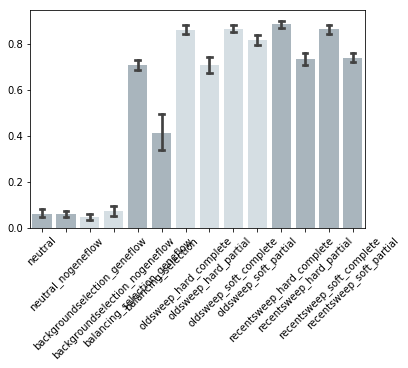

In [129]:
## Plot Fst
cols = ['#a6b5c0','#a6b5c0','#d3dee5','#d3dee5','#a6b5c0','#a6b5c0','#d3dee5','#d3dee5','#d3dee5','#d3dee5','#a6b5c0','#a6b5c0','#a6b5c0','#a6b5c0']
ax = sns.barplot(x="sim_type", y="Fst", data=sim_highmatechoice, estimator=numpy.mean, ci=95, capsize=.2, palette=cols)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

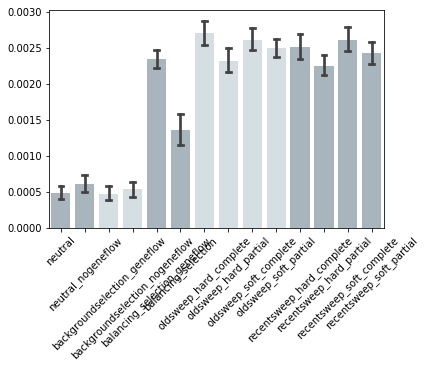

In [130]:
cols = ['#a6b5c0','#a6b5c0','#d3dee5','#d3dee5','#a6b5c0','#a6b5c0','#d3dee5','#d3dee5','#d3dee5','#d3dee5','#a6b5c0','#a6b5c0','#a6b5c0','#a6b5c0']
ax = sns.barplot(x="sim_type", y="Dxy", data=sim_highmatechoice, estimator=numpy.mean, ci=95, capsize=.2, palette=cols)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

<Figure size 360x4320 with 0 Axes>

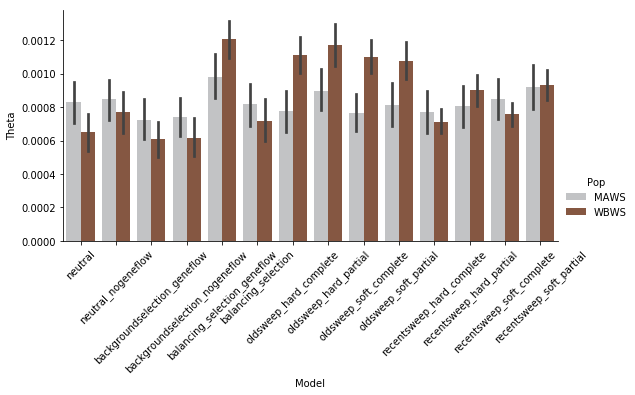

In [131]:
cols = ['#a6b5c0','#a6b5c0','#d3dee5','#d3dee5','#a6b5c0','#a6b5c0','#d3dee5','#d3dee5','#d3dee5','#d3dee5','#a6b5c0','#a6b5c0','#a6b5c0','#a6b5c0']
pi_slim = {'Model':[],'Theta':[],'Pop':[]}

for model in enumerate(sim_highmatechoice['sim_type']):
    pi_slim['Model'].append(model[1])
    pi_slim['Model'].append(model[1])
    pi_slim['Pop'].append('MAWS')
    pi_slim['Theta'].append(sim_highmatechoice['Theta1'][model[0]])
    pi_slim['Pop'].append('WBWS')
    pi_slim['Theta'].append(sim_highmatechoice['Theta2'][model[0]])

pi_slim = pd.DataFrame(pi_slim)

my_pal = {'MAWS':'#BBBDC0','WBWS':'#854020'}
plt.figure(figsize=(5, 60))
sns.catplot(data=pi_slim, kind="bar",x="Model", y="Theta", hue="Pop",ci=95, palette=my_pal, alpha=.9, height=4, aspect=2)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

<Figure size 360x4320 with 0 Axes>

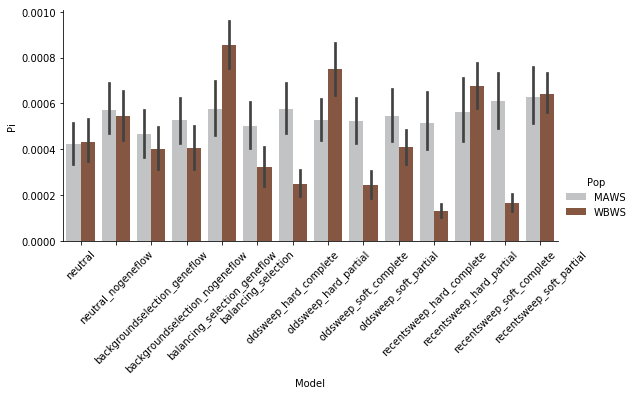

In [132]:
cols = ['#a6b5c0','#a6b5c0','#d3dee5','#d3dee5','#a6b5c0','#a6b5c0','#d3dee5','#d3dee5','#d3dee5','#d3dee5','#a6b5c0','#a6b5c0','#a6b5c0','#a6b5c0']
pi_slim = {'Model':[],'Pi':[],'Pop':[]}

for model in enumerate(sim_highmatechoice['sim_type']):
    pi_slim['Model'].append(model[1])
    pi_slim['Model'].append(model[1])
    pi_slim['Pop'].append('MAWS')
    pi_slim['Pi'].append(sim_highmatechoice['Pi1'][model[0]])
    pi_slim['Pop'].append('WBWS')
    pi_slim['Pi'].append(sim_highmatechoice['Pi2'][model[0]])

pi_slim = pd.DataFrame(pi_slim)

my_pal = {'MAWS':'#BBBDC0','WBWS':'#854020'}
plt.figure(figsize=(5, 60))
sns.catplot(data=pi_slim, kind="bar",x="Model", y="Pi", hue="Pop",ci=95, palette=my_pal, alpha=.9, height=4, aspect=2)
plt.xticks(rotation=45)